# **MODÈLE D'OPTIMISATION DES PUISSANCES**

### Optimiser le choix des puissances en utilisant le modèle sur la température intérieure

Dans cette dernière partie du projet, à partir d'un modèle expliquant la température intérieure dans les skids, nous voulons implémenter un modèle d'optimisation qui permettra de prédire la puissance minimale à fournir pour assurer dans les bâtiments une température minimale donnée.   

## **1. Importation des données**

#### Création d'un lien avec un Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import de modules Python

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install pulp # À n'exécuter que si pulp n'est pas installé sur votre ordi
from pulp import * 

### Importation des données

In [ ]:
#path = "/content/drive/MyDrive/Bureau d'étude/Codes/Données/"     # Orhiane et Victor
path = "/content/drive/MyDrive/4GM/Bureau d'étude/Codes/Données/" # Manon et Anouck

df_data = pd.read_csv(path + "données_Python.csv")
df_data['DT'] = pd.to_datetime(df_data['DT'], format='%Y-%m-%d %H:%M:%S') # Reconversion en objets Timestamp
df_data = pd.concat([df_data,pd.get_dummies(df_data.day_moment.map(int), prefix='day_moment', drop_first=True)], axis=1) # Création de dummies pour la variable 'day_moment'
del df_data['day_moment'] # on retire la variable 'day_moment' qui est désormais remplacée par toutes les dummies
df_data

,skidID,DT,Puissance,IndoorTemp,OutdoorTemp,Puissance_surf,Puissance_surf_030,Puissance_surf_060,Puissance_surf_090,Puissance_surf_120,IndoorTemp_030,IndoorTemp_060,IndoorTemp_90to120,deltaIndoorTemp,skidType,area,day_moment_2,day_moment_3,day_moment_4,day_moment_5,day_moment_6,day_moment_7,day_moment_8,day_moment_9,day_moment_10,day_moment_11,day_moment_12
0,SSH0000001,2019-10-20 02:00:00,3.50,19.920000,12.0,10.358105,10.278631,10.389011,10.424039,10.406030,19.895556,19.799722,19.404167,0.491389,Resid_Rad_GoodIns,314568.48,1,0,0,0,0,0,0,0,0,0,0
1,SSH0000001,2019-10-20 02:10:00,2.95,19.915000,12.5,10.384596,10.296292,10.362520,10.419918,10.402036,19.910000,19.850000,19.406778,0.503222,Resid_Rad_GoodIns,314568.48,1,0,0,0,0,0,0,0,0,0,0
2,SSH0000001,2019-10-20 02:20:00,3.75,19.896667,13.0,10.649509,10.287461,10.331614,10.416975,10.410867,19.916111,19.886667,19.424000,0.492111,Resid_Rad_GoodIns,314568.48,1,0,0,0,0,0,0,0,0,0,0
3,SSH0000001,2019-10-20 02:30:00,3.25,19.896667,13.0,10.887931,10.464070,10.371351,10.414031,10.434047,19.910556,19.903056,19.473444,0.437111,Resid_Rad_GoodIns,314568.48,1,0,0,0,0,0,0,0,0,0,0
4,SSH0000001,2019-10-20 02:40:00,3.55,19.913333,13.0,10.570035,10.640679,10.468485,10.455240,10.475108,19.902778,19.906389,19.542222,0.360556,Resid_Rad_GoodIns,314568.48,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380314,SSH0000574,2020-04-08 18:10:00,0.60,19.895000,2.0,13.079986,13.316152,13.403352,13.403352,12.612194,19.895500,19.898300,19.875000,0.020500,Resid_FH_GoodIns,45871.61,0,0,0,0,0,0,0,0,1,0,0
380315,SSH0000574,2020-04-11 21:40:00,0.55,20.680000,0.0,11.553987,11.505543,11.505543,9.295268,8.742699,20.660000,20.660000,20.770000,-0.110000,Resid_FH_GoodIns,45871.61,0,0,0,0,0,0,0,0,0,1,0
380316,SSH0000574,2020-04-11 21:50:00,0.50,20.683333,0.0,11.444987,11.541876,11.517654,10.040100,9.055064,20.665000,20.665000,20.770000,-0.105000,Resid_FH_GoodIns,45871.61,0,0,0,0,0,0,0,0,0,1,0
380317,SSH0000574,2020-04-11 22:00:00,0.55,20.688000,0.0,11.553987,11.481321,11.503121,10.766766,9.539508,20.676111,20.668667,20.770000,-0.093889,Resid_FH_GoodIns,45871.61,0,0,0,0,0,0,0,0,0,0,1


## **2. Implémentation du modèle expliquant la température intérieure**

 Définition par type de skid des fonctions liant températures intérieures et notamment les puissances surfaciques

In [ ]:
from sklearn.linear_model import LinearRegression

coefs_par_type = {} # contiendra les coefficients de régression de chaque modèle par type de skids

modele = LinearRegression(fit_intercept=False)
variables_explicatives = ['OutdoorTemp', 'Puissance_surf', 'Puissance_surf_030', 'Puissance_surf_060', 'Puissance_surf_090', 'Puissance_surf_120']

types_skids = sorted(set(df_data.skidType))
for type_skid in types_skids:
  donnees = df_data[df_data.skidType == type_skid].copy()
  X = donnees[variables_explicatives]
  y = donnees['IndoorTemp']

  modele.fit(X,y)
  coefs_par_type[type_skid] = [modele.intercept_] + list(modele.coef_)

print(coefs_par_type)

{'Resid_FH_GoodIns': [0.0, 0.598734457261208, 0.7785502130321441, -1.2800411135770904, 2.2248232138169826, -3.2797807513074537, 2.5811945596812382], 'Resid_Rad_BadIns': [0.0, -0.5004565684928527, 0.049435355077905245, -0.060209846180335466, 0.11383543774628131, -0.22069600870170203, 0.2239120766970238], 'Resid_Rad_GoodIns': [0.0, 0.46624004312849293, 0.44576960705085317, -0.5740756013487878, 1.0753891488721976, -1.709351667023782, 1.8656699180521152]}


## **3. Implémentation du problème d'optimisation des puissances**

### **3.a. Récupération de données**

On veut récupérer les endroits (i.e. les indices des lignes dans le dataframe des données) où pour chacuns des skid, **84** données successives se trouvent :

In [ ]:
dates = pd.date_range(df_data['DT'].min(), df_data['DT'].max(), freq='10min') # range de dates allant de la première date observée à la dernière date observée dans les données

# >> Création de la liste d'indices de blocs que l'on aurait si toutes les dates se suivaient :

list_indexs_blocs_th = [] # liste théorique des indices des blocs (s'il y avait bien une donnée toutes les 10 minutes)
nb_blocs = int((len(dates)-12)/72)
for i in range(nb_blocs):
  list_indexs_blocs_th.append(range(i*72, (i+1)*72 + 12)) # le +12 étant en fait pour avoir 12 données en plus au début du bloc


# >> Récupération des indices des blocs complets :

df_dates = pd.DataFrame({'DT' : dates})
skids = sorted(set(df_data['skidID']))
dic_indexs_blocs = {skid:[np.nan for i in range(nb_blocs)] for skid in skids} # Contiendra les indices des données pour lesquelles le bloc entier ne contient aucune ligne avec des données manquantes.
                                                                              # On initialise cette liste avec des NaN, comme si pour aucun skid il n'y avait de blocs sans une données manquantes.
                                                                              # On remplira ce tableau avec les indices de blocs complets uniquement (sinon la valeur restera à NaN).

# Pour chaque skid, on regarde pour chaque blocs d'indexes théoriques, si pour ce skid et dans ce bloc il y a des données manquantes (i.e toutes les dates ne sont pas consécutives)
for skid in skids: 
  df_local = df_data[df_data.skidID == skid].copy() # copie du data frame pour les données de ce skid
  df_local['indexs_df_data'] = df_local.index       # permet de conserver les indices "absolus" du dataframe 'df_data'
  df_local = df_dates.merge(df_local, how='outer', on='DT') # On obtient un dataframe avec une ligne toutes les 10 min et des NaN lorsqu'on n'a pas de données pour une certaines dates
                                                            # De plus, les données sont ainsi rangées dans l'ordre chronologique
  i = 0 # compteur qui sert à parcourir 'list_indexs_blocs_th'
  for indexs_bloc in list_indexs_blocs_th:
    if not np.any(df_local.loc[indexs_bloc].IndoorTemp.isna()): # Si pour cet ensemble de 84 données consécutives il n'y a pas une seule ligne avec des données manquantes
      dic_indexs_blocs[skid][i] = list(df_local['indexs_df_data'][indexs_bloc].map(int))
    i += 1  

del df_local

# Création du dataframe qui contiendra les indices "absolus" de blocs pour tous les skids. Ces blocs ont les particularités suivantes :
# -> on ne conserve que des blocs qui ont 84 données consécutives dans le temps, i.e. on a une donnée toutes les 10 minutes pour ces 84 données
# -> chaque bloc comporte une période de temps, et on ne conserve que les blocs (les temps) qui sont complets pour chacun des skids
df_indexs_blocs = pd.DataFrame(dic_indexs_blocs)
df_indexs_blocs.dropna(inplace=True)
df_indexs_blocs.index = range(df_indexs_blocs.shape[0])
df_indexs_blocs.head(3)

,SSH0000001,SSH0000068,SSH0000121,SSH0000198,SSH0000218,SSH0000241,SSH0000258,SSH0000275,SSH0000339,SSH0000341,SSH0000353,SSH0000381,SSH0000402,SSH0000449,SSH0000457,SSH0000518,SSH0000574
0,"[10801, 10802, 10803, 10804, 10805, 10806, 108...","[35060, 35061, 35062, 35063, 35064, 35065, 350...","[55772, 55773, 55774, 55775, 55776, 55777, 557...","[76844, 76845, 76846, 76847, 76848, 76849, 768...","[97504, 97505, 97506, 97507, 97508, 97509, 975...","[116025, 116026, 116027, 116028, 116029, 11603...","[139710, 139711, 139712, 139713, 139714, 13971...","[163338, 163339, 163340, 163341, 163342, 16334...","[183752, 183753, 183754, 183755, 183756, 18375...","[207564, 207565, 207566, 207567, 207568, 20756...","[231337, 231338, 231339, 231340, 231341, 23134...","[254008, 254009, 254010, 254011, 254012, 25401...","[277631, 277632, 277633, 277634, 277635, 27763...","[300714, 300715, 300716, 300717, 300718, 30071...","[323496, 323497, 323498, 323499, 323500, 32350...","[346895, 346896, 346897, 346898, 346899, 34690...","[368356, 368357, 368358, 368359, 368360, 36836..."
1,"[13449, 13450, 13451, 13452, 13453, 13454, 134...","[37718, 37719, 37720, 37721, 37722, 37723, 377...","[56656, 56657, 56658, 56659, 56660, 56661, 566...","[79489, 79490, 79491, 79492, 79493, 79494, 794...","[100131, 100132, 100133, 100134, 100135, 10013...","[118661, 118662, 118663, 118664, 118665, 11866...","[142356, 142357, 142358, 142359, 142360, 14236...","[165958, 165959, 165960, 165961, 165962, 16596...","[186408, 186409, 186410, 186411, 186412, 18641...","[210219, 210220, 210221, 210222, 210223, 21022...","[233970, 233971, 233972, 233973, 233974, 23397...","[256663, 256664, 256665, 256666, 256667, 25666...","[280241, 280242, 280243, 280244, 280245, 28024...","[303369, 303370, 303371, 303372, 303373, 30337...","[326019, 326020, 326021, 326022, 326023, 32602...","[349453, 349454, 349455, 349456, 349457, 34945...","[370965, 370966, 370967, 370968, 370969, 37097..."
2,"[13665, 13666, 13667, 13668, 13669, 13670, 136...","[37934, 37935, 37936, 37937, 37938, 37939, 379...","[56871, 56872, 56873, 56874, 56875, 56876, 568...","[79704, 79705, 79706, 79707, 79708, 79709, 797...","[100347, 100348, 100349, 100350, 100351, 10035...","[118877, 118878, 118879, 118880, 118881, 11888...","[142572, 142573, 142574, 142575, 142576, 14257...","[166174, 166175, 166176, 166177, 166178, 16617...","[186624, 186625, 186626, 186627, 186628, 18662...","[210435, 210436, 210437, 210438, 210439, 21044...","[234186, 234187, 234188, 234189, 234190, 23419...","[256879, 256880, 256881, 256882, 256883, 25688...","[280457, 280458, 280459, 280460, 280461, 28046...","[303585, 303586, 303587, 303588, 303589, 30359...","[326235, 326236, 326237, 326238, 326239, 32624...","[349669, 349670, 349671, 349672, 349673, 34967...","[371181, 371182, 371183, 371184, 371185, 37118..."


In [ ]:
# Pour tester :
print(df_data[['skidID','DT','Puissance','IndoorTemp','OutdoorTemp']].loc[df_indexs_blocs.loc[0,'SSH0000001'][0]])
print(df_data[['skidID','DT','Puissance','IndoorTemp','OutdoorTemp']].loc[df_indexs_blocs.loc[0,'SSH0000121'][0]])

skidID                  SSH0000001
DT             2020-01-05 02:00:00
Puissance                     10.3
IndoorTemp                   18.69
OutdoorTemp                    -13
Name: 10801, dtype: object
skidID                  SSH0000121
DT             2020-01-05 02:00:00
Puissance                        1
IndoorTemp                  20.735
OutdoorTemp                    -13
Name: 55772, dtype: object


In [ ]:
#print('Nombre de blocs dans lesquels il manque au moins une donnée :\n', np.sum(pd.DataFrame(dic_indexs_blocs).isna()), sep='')

### **3.b. Modèle d'optimisation n°1** - prédictions toutes les 10 minutes

#### 3.b.i. Écriture mathématique

**Variables** :
*   $P_{i,t}$ : puissance à envoyer au skid $i\in I$ au temps $t\in \mathcal T:=[10\min,20\min,...,11\text{h}50\min,12\text{h}]$. 
C'est notre **variable de décision**.
*   $\tilde P_{i,t}$ : puissance surfacique du skid $i\in I$ au temps $t\in \mathcal T$
*   $T_{i,t}$ : température intérieure du skid $i\in I$ au temps $t\in \mathcal T$  
  
$\phantom{saut de ligne}$

Variables intermédaires :
*   $\tilde p^{-30}_{i,t}$ : valeur de la puissance surfacique moyenne sur les 30 minutes passées du skid $i\in I$ au temps $t\in \mathcal T$
*   $\tilde p^{-60}_{i,t}$ : valeur de la puissance surfacique moyenne sur les 60 minutes passées du skid $i\in I$ au temps $t\in \mathcal T$
*   $\tilde p^{-90}_{i,t}$ : valeur de la puissance surfacique moyenne sur les 90 minutes passées du skid $i\in I$ au temps $t\in \mathcal T$
*   $\tilde p^{-120}_{i,t}$ : valeur de la puissance surfacique moyenne sur les 120 minutes passées du skid $i\in I$ au temps $t\in \mathcal T$

$\phantom{saut de ligne}$

$$\begin{array}{rllr}
\min  & \sum\limits_{i\in I} \sum\limits_{t\in \mathcal T} P_{i,t}\\
 s.c. & T_{i,t} = f_i(T^{\text{ext}}_{t},\tilde P_{i,t},\tilde p^{-30}_{i,t},\tilde p^{-60}_{i,t},\tilde p^{-90}_{i,t},\tilde p^{-120}_{i,t}) & \forall i\in I, \forall t\in \mathcal T & (1)\\
      & T^{\text{int}}_\min \le T_{i,t} \le T^{\text{int}}_\max & \forall i \in I, \forall t \in \mathcal T & (2)\\
      & P_{i,t} = \tilde P_{i,t} \times \text{surface}_{\,i} & \forall i \in I, \forall t \in \mathcal T & (3)\\
      & \sum\limits_{i\in I} P_{i,t} \le P_\text{MAX}&  \forall t \in \mathcal T & (4)\\
      & \phantom{saut de ligne}\\
      & \tilde p^{-30}_{i,t} = \text{mean}(\tilde P_{i,t-30"},\tilde P_{i,t-20"},\tilde P_{i,t-10"}) & \forall i \in I, \forall t \in \mathcal T & (5)\\
      & \tilde p^{-60}_{i,t} = \text{mean}(\tilde P_{i,t-60"},\tilde P_{i,t-50"},...,\tilde P_{i,t-10"}) & \forall i \in I, \forall t \in \mathcal T & (6)\\
      & \tilde p^{-90}_{i,t} = \text{mean}(\tilde P_{i,t-90"},\tilde P_{i,t-80"},...,\tilde P_{i,t-10"}) & \forall i \in I, \forall t \in \mathcal T & (7)\\
      & \tilde p^{-120}_{i,t} = \text{mean}(\tilde P_{i,t-120"},\tilde P_{i,t-110"},...,\tilde P_{i,t-10"}) & \forall i \in I, \forall t \in \mathcal T & (8)\\
      & \phantom{saut de ligne}\\
      & \big\lvert P_{i,t} - P_{i,t-10"} \big\rvert \le C_\text{norme1} & \forall i \in I, \forall t \in \mathcal T\backslash\{10\min\} & (9)\\
      & \phantom{saut de ligne}\\
      & P_{i,t},~ \tilde P_{i,t},~ T_{i,t} \in \mathbb{R}_+\\
\end{array}$$

$\phantom{saut de ligne}$

À noter que pour $t\in [-110\min,-100\min,...,0\min]$, on connait déjà les valeurs de $\tilde P_{i,t}$ qui seront ainsi entrées en données du modèles. Les calculs de $\tilde p^{-30}_{i,t}$, $\tilde p^{-60}_{i,t}$, $\tilde p^{-90}_{i,t}$, $\tilde p^{-120}_{i,t}$ ne poseront donc pas de problème quelque soit le temps $t\in \mathcal T$.

#### 3.b.ii. Données du modèle

In [ ]:
Tps = list(range(10,12*60+1,10)) # [10min, 20min, ..., 12*60min]
Tps_passe = list(range(-110,1,10)) # [-110min, -100min, ..., 0min]
skids = sorted(set(df_data['skidID'])) # ['SSH0000001', 'SSH0000068', 'SSH0000121', 'SSH0000198', 'SSH0000218', 'SSH0000241',
                                       #  'SSH0000258', 'SSH0000275', 'SSH0000339', 'SSH0000341', 'SSH0000353', 'SSH0000381',
                                       #  'SSH0000402', 'SSH0000449', 'SSH0000457', 'SSH0000518', 'SSH0000574']
surface = dict(df_data.groupby('skidID').area.min()) # {'SSH0000001': 314568.48, 'SSH0000068': 24652.15, 'SSH0000121': 4934.88, 'SSH0000198': 122760.05, 'SSH0000218': 44321.52, 'SSH0000241': 50871.21,
                                                     #  'SSH0000258': 18782.84, 'SSH0000275': 51617.36, 'SSH0000339': 51941.47, 'SSH0000341': 55172.32, 'SSH0000353': 9654.07, 'SSH0000381': 100816.27, 
                                                     #  'SSH0000402': 27081.2431, 'SSH0000449': 102630.41, 'SSH0000457': 73812.91, 'SSH0000518': 41253.4933, 'SSH0000574': 45871.61}
skid_types = dict(df_data.groupby('skidID').skidType.min()) # {'SSH0000001': 'Resid_Rad_GoodIns', 'SSH0000068': 'Resid_FH_GoodIns', 'SSH0000121': 'Resid_Rad_BadIns', 'SSH0000198': 'Resid_Rad_GoodIns',
                                                            # 'SSH0000218': 'Resid_Rad_GoodIns', 'SSH0000241': 'Resid_FH_GoodIns', 'SSH0000258': 'Resid_Rad_GoodIns', 'SSH0000275': 'Resid_Rad_GoodIns', 
                                                            # 'SSH0000339': 'Resid_Rad_GoodIns', 'SSH0000341': 'Resid_FH_GoodIns', 'SSH0000353': 'Resid_FH_GoodIns', 'SSH0000381': 'Resid_FH_GoodIns',
                                                            # 'SSH0000402': 'Resid_Rad_GoodIns', 'SSH0000449': 'Resid_Rad_BadIns', 'SSH0000457': 'Resid_FH_GoodIns', 'SSH0000518': 'Resid_Rad_BadIns',
                                                            # 'SSH0000574': 'Resid_FH_GoodIns'}

Choisir parmi les 17 ensembles de données, le bloc de 84 données sur lequel 
on appliquera le modèle d'optimisation (donner un chiffre entre 1 et 17) :

1

On travaillera donc sur l'intervalle de temps de 2020-01-05 02:00:00 à 2020-01-05 13:50:00 



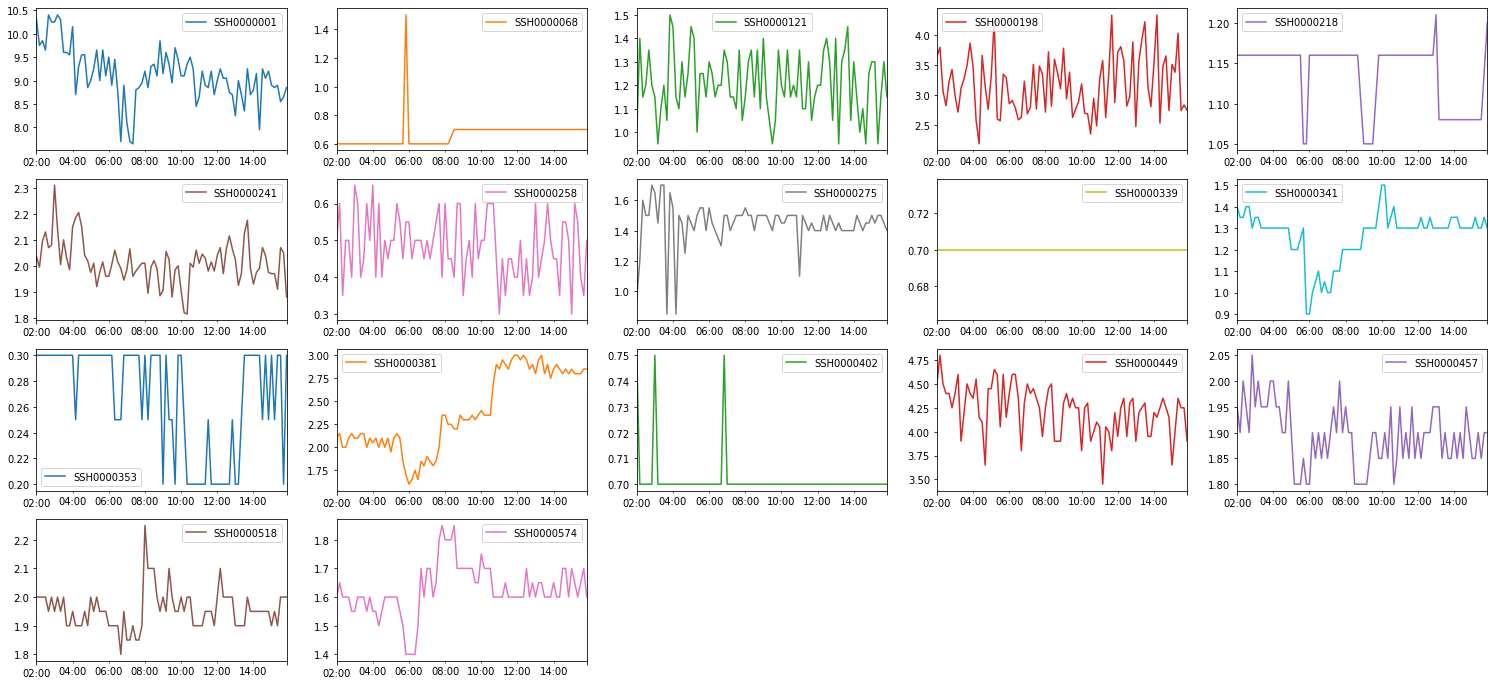

In [ ]:
# Choix des données sur lesquelles on travaille :

puissances_surf  = {} # contiendra pour chaque skid, les puissances surfaciques
temperatures_int = {} # contiendra pour chaque skid, les températures intérieures

n = df_indexs_blocs.shape[0]
print('Choisir parmi les ',n," ensembles de données, le bloc de 84 données sur lequel \non appliquera le modèle d'optimisation (donner un chiffre entre 1 et ",n,') :\n', sep='')
i = input()

# Pour récupérer les informations qui ne dépendent pas du skid
indexs_skid = df_indexs_blocs[skids[0]][int(i)-1] 
dates = dict(zip(Tps, df_data.loc[indexs_skid]['DT']))
temperatures_ext = dict(zip(Tps, df_data.loc[indexs_skid]['OutdoorTemp'][12:]))


df_affichage = pd.DataFrame(index = list(df_data.loc[indexs_skid]['DT']))

print("\nOn travaillera donc sur l'intervalle de temps de",dates[Tps[0]],'à',dates[Tps[-1]],'\n')

for skid in skids:
  indexs_skid = df_indexs_blocs[skid][int(i)-1]

  puissances_surf[skid]  = dict(zip(Tps_passe+Tps, df_data.loc[indexs_skid]['Puissance_surf']))
  temperatures_int[skid] = dict(zip(Tps_passe+Tps, df_data.loc[indexs_skid]['IndoorTemp']))

  df_affichage[skid] = list(df_data.loc[indexs_skid]['Puissance'])

df_affichage.plot(subplots=True, layout=(4, 5), figsize=(26, 12), sharex=False)
plt.title('Puissances étudiées', fontsize=18)
plt.show()

#### 3.b.iii. Modèle et résultats

In [ ]:
# Paramètres :

Tint_min = 18    # °C
Tint_max = 28    # °C
Pmax     = 34.3  # MW

C_norme1 = 50

In [ ]:
# ['SSH0000001', 'SSH0000068', 'SSH0000121', 'SSH0000198', 'SSH0000218', 'SSH0000241', 'SSH0000258', 'SSH0000275', 'SSH0000339',
#  'SSH0000341', 'SSH0000353', 'SSH0000381', 'SSH0000402', 'SSH0000449', 'SSH0000457', 'SSH0000518', 'SSH0000574']

skids = ['SSH0000001', 'SSH0000068', 'SSH0000121', 'SSH0000198', 'SSH0000218', 'SSH0000241', 'SSH0000258', 'SSH0000275', 'SSH0000339',
         'SSH0000341', 'SSH0000353', 'SSH0000381', 'SSH0000402', 'SSH0000457', 'SSH0000518', 'SSH0000574']

In [ ]:
set(df_data.skidType[df_data.skidID=='SSH0000449'])

{'Resid_Rad_BadIns'}

In [ ]:
# Écriture du problème
prob = LpProblem("Puissances", LpMinimize)

# Initialisation des variables
P  = LpVariable.dicts("P", (skids,Tps), cat = "Continuous", lowBound=0)
Ps = LpVariable.dicts("Ps", (skids,Tps_passe + Tps), cat = "Continuous", lowBound=0)
T  = LpVariable.dicts("T", (skids,Tps_passe + Tps), cat = "Continuous", lowBound=0)

ps30  = LpVariable.dicts("ps-30", (skids,Tps), cat = "Continuous", lowBound=0) 
ps60  = LpVariable.dicts("ps-60", (skids,Tps), cat = "Continuous", lowBound=0)
ps90  = LpVariable.dicts("ps-90", (skids,Tps), cat = "Continuous", lowBound=0)
ps120 = LpVariable.dicts("ps-120", (skids,Tps), cat = "Continuous", lowBound=0)


# Objectif
prob += lpSum(lpSum(P[i][t] for t in Tps) for i in skids), "Objectif"


# Entrée des données déjà connues du passé pour Ps et T
for i in skids:
  for t in Tps_passe:
    prob += Ps[i][t] == puissances_surf[i][t]


for t in Tps:
  for i in skids:
    coef = coefs_par_type[skid_types[i]]
    prob += T[i][t] == coef[0] + coef[1]*temperatures_ext[t] + coef[2]*Ps[i][t] + coef[3]*ps30[i][t] + coef[4]*ps60[i][t] + coef[5]*ps90[i][t] + coef[6]*ps120[i][t]
    prob += T[i][t] <= Tint_max
    prob += T[i][t] >= Tint_min

    prob += ps30[i][t] == lpSum([ Ps[i][t-30], Ps[i][t-20], Ps[i][t-10] ])/3
    prob += ps60[i][t] == lpSum([ Ps[i][t-60], Ps[i][t-50], Ps[i][t-40], Ps[i][t-30], Ps[i][t-20], Ps[i][t-10] ])/6
    prob += ps90[i][t] == lpSum([ Ps[i][t-90], Ps[i][t-80], Ps[i][t-70], Ps[i][t-60], Ps[i][t-50], Ps[i][t-40], Ps[i][t-30], Ps[i][t-20], Ps[i][t-10] ])/9
    prob += ps120[i][t] == lpSum([ Ps[i][t-120], Ps[i][t-110], Ps[i][t-100], Ps[i][t-90], Ps[i][t-80], Ps[i][t-70], Ps[i][t-60], Ps[i][t-50], Ps[i][t-40], Ps[i][t-30], Ps[i][t-20], Ps[i][t-10] ])/12

for t in Tps:
  for i in skids:
    prob += P[i][t] == Ps[i][t] * surface[i] * 10**(-6)

for t in Tps:
  prob += lpSum(P[i][t] for i in skids) <= Pmax

for i in skids:
  for t in Tps[1:]:
    prob += P[i][t] - P[i][t-10] <= C_norme1
    prob += P[i][t-10] - P[i][t] <= C_norme1

prob.solve(PULP_CBC_CMD())

print('status :',LpStatus[prob.status])
print('valeur objectif :',value(prob.objective))

print('\nPuissances :')
print('    heures :',end='')
for t in Tps:
    print("{:10d}".format(t), end=' ')
print()
for i in skids:
  print(' ',i,': ', end='')
  for t in Tps:
    print("{:10.7f}".format(P[i][t].varValue), end=' ')
  print()

print('\nTempératures intérieures :')
print('   minutes :  ',end='')
for t in Tps:
    print("{:4d}".format(t), end=' ')
print()
for i in skids:
  print(' ',i,': ', end='')
  for t in Tps:
    print("{:4.1f}".format(T[i][t].varValue), end=' ')
  print()

SSH0000001


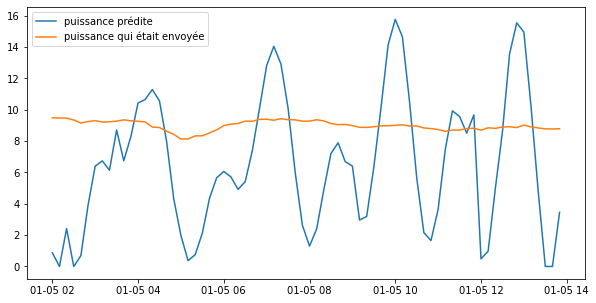

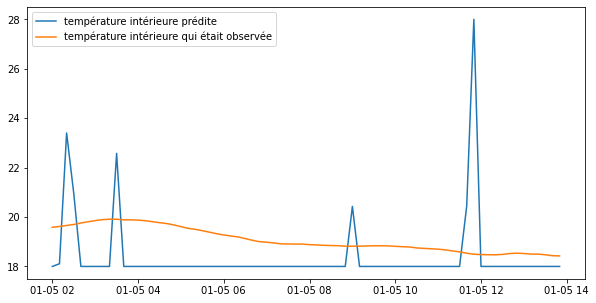

In [ ]:
i = 'SSH0000001'
print(i)
p_pred = []
p_real = []
T_pred = []
for t in Tps:
  p_pred.append(P[i][t].varValue)
  p_real.append(puissances_surf[i][t] * surface[i] * 10**(-6))
  T_pred.append(T[i][t].varValue)

plt.figure(figsize=(10,5))
plt.plot(list(dates.values()), p_pred, label='puissance prédite')
plt.plot(list(dates.values()), p_real, label='puissance qui était envoyée')
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.plot(list(dates.values()), T_pred, label='température intérieure prédite')
plt.plot(list(dates.values()), list(temperatures_int[i].values())[12:], label='température intérieure qui était observée')
plt.legend()
plt.show()

### **3.c. Modèle d'optimisation n°2** - prédictions toutes les 30 minutes


#### 3.c.i. Écriture mathématique

**Variables** :
*   $P_{i,t}$ : puissance à envoyer au skid $i\in I$ au temps $t\in \mathcal T:=[30\min,1\text{h},1\text{h}30\min,...,11\text{h}30\min,12\text{h}]$.    
C'est notre **variable de décision**.
*   $\tilde P_{i,t}$ : puissance surfacique du skid $i\in I$ au temps $t\in \mathcal T$
*   $T_{i,t}$ : température intérieure du skid $i\in I$ au temps $t\in \mathcal T$  
  
$\phantom{saut de ligne}$

Variables intermédaires :
*   $\tilde p^{-30}_{i,t}$ : valeur de la puissance surfacique moyenne sur les 30 minutes passées du skid $i\in I$ au temps $t\in \mathcal T$
*   $\tilde p^{-60}_{i,t}$ : valeur de la puissance surfacique moyenne sur les 60 minutes passées du skid $i\in I$ au temps $t\in \mathcal T$
*   $\tilde p^{-90}_{i,t}$ : valeur de la puissance surfacique moyenne sur les 90 minutes passées du skid $i\in I$ au temps $t\in \mathcal T$
*   $\tilde p^{-120}_{i,t}$ : valeur de la puissance surfacique moyenne sur les 120 minutes passées du skid $i\in I$ au temps $t\in \mathcal T$




$\phantom{saut de ligne}$

$$\begin{array}{rllr}
\min  & \sum\limits_{i\in I} \sum\limits_{t\in \mathcal T} P_{i,t}\\
 s.c. & T_{i,t} = f_i(T^{\text{ext}}_{t},\tilde P_{i,t},\tilde p^{-30}_{i,t},\tilde p^{-60}_{i,t},\tilde p^{-90}_{i,t},\tilde p^{-120}_{i,t}) & \forall i\in I, \forall t\in \mathcal T & (1)\\
      & T^{\text{int}}_\min \le T_{i,t} \le T^{\text{int}}_\max & \forall i \in I, \forall t \in \mathcal T & (2)\\
      & P_{i,t} = \tilde P_{i,t} \times \text{surface}_{\,i} & \forall i \in I, \forall t \in \mathcal T & (3)\\
      & \sum\limits_{i\in I} P_{i,t} \le P_\text{MAX}&  \forall t \in \mathcal T & (4)\\
      & \phantom{saut de ligne}\\
      & \tilde p^{-30}_{i,t} = \tilde P_{i,t-30"} & \forall i \in I, \forall t \in \mathcal T & (5)\\
      & \tilde p^{-60}_{i,t} = \text{mean}(\tilde P_{i,t-60"},\tilde P_{i,t-30"}) & \forall i \in I, \forall t \in \mathcal T & (6)\\
      & \tilde p^{-90}_{i,t} = \text{mean}(\tilde P_{i,t-90"},\tilde P_{i,t-60"},\tilde P_{i,t-30"}) & \forall i \in I, \forall t \in \mathcal T & (7)\\
      & \tilde p^{-120}_{i,t} = \text{mean}(\tilde P_{i,t-120"},\tilde P_{i,t-90"},\tilde P_{i,t-60"},\tilde P_{i,t-30"}) & \forall i \in I, \forall t \in \mathcal T & (8)\\
      & \phantom{saut de ligne}\\
      & \big\lvert P_{i,t} - P_{i,t-30"} \big\rvert \le C_\text{norme1} & \forall i \in I, \forall t \in \mathcal T & (9)\\
      & \phantom{saut de ligne}\\
      & P_{i,t},~ \tilde P_{i,t},~ T_{i,t} \in \mathbb{R}_+\\
\end{array}$$

$\phantom{saut de ligne}$

À noter que pour $t\in [-90\min,-60\min,-30\min,0\min]$, on connait déjà les valeurs de $\tilde P_{i,t}$ qui seront ainsi entrées en données du modèles. Les calculs de $\tilde p^{-30}_{i,t}$, $\tilde p^{-60}_{i,t}$, $\tilde p^{-90}_{i,t}$, $\tilde p^{-120}_{i,t}$ ne poseront donc pas de problème quelque soit le temps $t\in \mathcal T$.

#### 3.c.ii. Données du modèle

In [ ]:
Tps = list(range(30,12*60+1,30)) # [30min, 1h, 1h30min, ..., 12*60min]
Tps_passe = list(range(-90,1,10)) # [-90min, -60min, -30min, 0min]
skids = sorted(set(df_data['skidID'])) # ['SSH0000001', 'SSH0000068', 'SSH0000121', 'SSH0000198', 'SSH0000218', 'SSH0000241',
                                       #  'SSH0000258', 'SSH0000275', 'SSH0000339', 'SSH0000341', 'SSH0000353', 'SSH0000381',
                                       #  'SSH0000402', 'SSH0000449', 'SSH0000457', 'SSH0000518', 'SSH0000574']
surface = dict(df_data.groupby('skidID').area.min()) # {'SSH0000001': 314568.48, 'SSH0000068': 24652.15, 'SSH0000121': 4934.88, 'SSH0000198': 122760.05, 'SSH0000218': 44321.52, 'SSH0000241': 50871.21,
                                                     #  'SSH0000258': 18782.84, 'SSH0000275': 51617.36, 'SSH0000339': 51941.47, 'SSH0000341': 55172.32, 'SSH0000353': 9654.07, 'SSH0000381': 100816.27, 
                                                     #  'SSH0000402': 27081.2431, 'SSH0000449': 102630.41, 'SSH0000457': 73812.91, 'SSH0000518': 41253.4933, 'SSH0000574': 45871.61}
skid_types = dict(df_data.groupby('skidID').skidType.min()) # {'SSH0000001': 'Resid_Rad_GoodIns', 'SSH0000068': 'Resid_FH_GoodIns', 'SSH0000121': 'Resid_Rad_BadIns', 'SSH0000198': 'Resid_Rad_GoodIns',
                                                            # 'SSH0000218': 'Resid_Rad_GoodIns', 'SSH0000241': 'Resid_FH_GoodIns', 'SSH0000258': 'Resid_Rad_GoodIns', 'SSH0000275': 'Resid_Rad_GoodIns', 
                                                            # 'SSH0000339': 'Resid_Rad_GoodIns', 'SSH0000341': 'Resid_FH_GoodIns', 'SSH0000353': 'Resid_FH_GoodIns', 'SSH0000381': 'Resid_FH_GoodIns',
                                                            # 'SSH0000402': 'Resid_Rad_GoodIns', 'SSH0000449': 'Resid_Rad_BadIns', 'SSH0000457': 'Resid_FH_GoodIns', 'SSH0000518': 'Resid_Rad_BadIns',
                                                            # 'SSH0000574': 'Resid_FH_GoodIns'}

Choisir parmi les 17 ensembles de données, le bloc de 84 données sur lequel 
on appliquera le modèle d'optimisation (donner un chiffre entre 1 et 17) :


On travaillera donc sur l'intervalle de temps de 2020-01-05 02:00:00 à 2020-01-05 15:50:00 



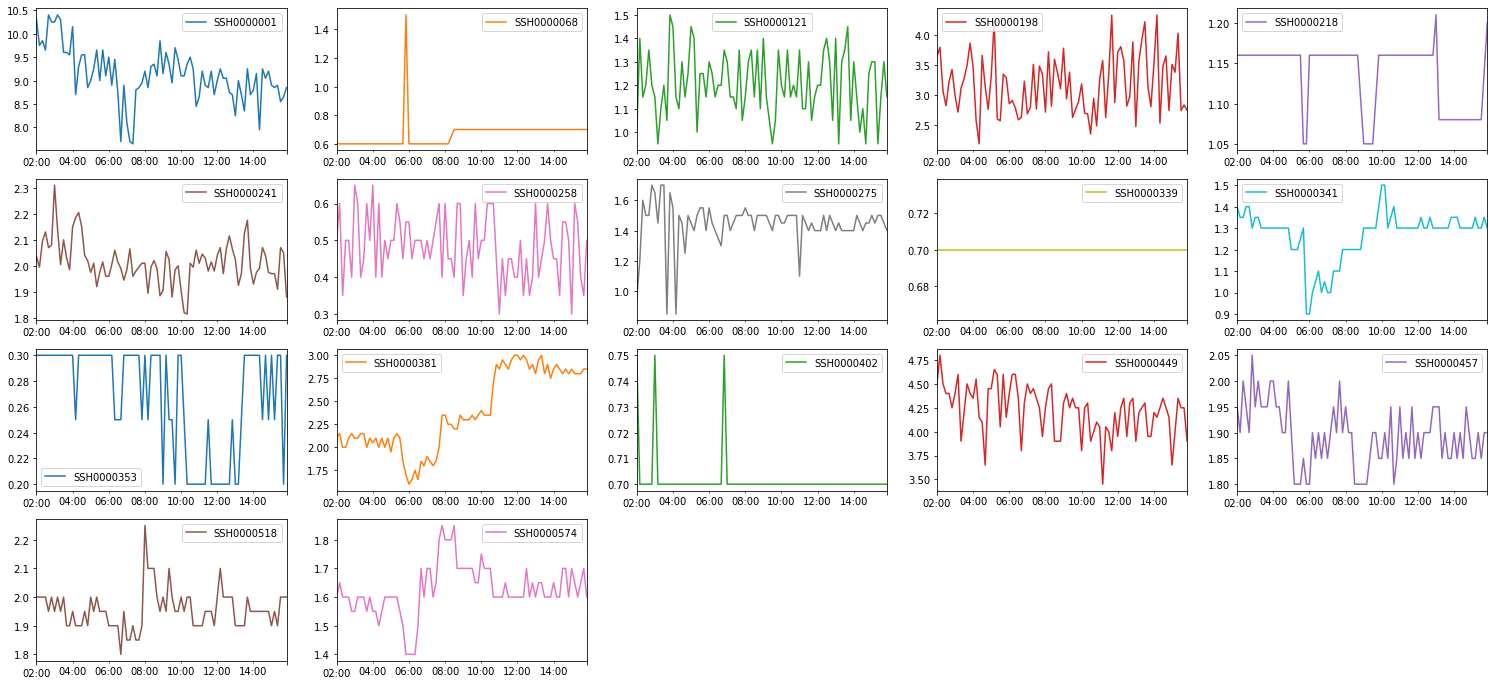

In [ ]:
# Choix des données sur lesquelles on travaille :

puissances_surf  = {} # contiendra pour chaque skid, les puissances surfaciques
temperatures_int = {} # contiendra pour chaque skid, les températures intérieures
#temperatures_ext       contiendra les températures extérieures

n = df_indexs_blocs.shape[0]
print('Choisir parmi les ',n," ensembles de données, le bloc de 84 données sur lequel \non appliquera le modèle d'optimisation (donner un chiffre entre 1 et ",n,') :\n', sep='')
i = input()

# Pour récupérer les informations qui ne dépendent pas du skid
indexs_skid = df_indexs_blocs[skids[0]][int(i)-1] 
temperatures_ext = dict(zip(range(10,12*60+1,10), df_data.loc[indexs_skid]['OutdoorTemp'][12:]))

dates = list(df_data.loc[indexs_skid]['DT'])
df_affichage = pd.DataFrame(index = dates)

print("\nOn travaillera donc sur l'intervalle de temps de",dates[0],'à',dates[-1],'\n')

for skid in skids:
  indexs_skid = df_indexs_blocs[skid][int(i)-1]

  puissances_surf[skid] = dict(zip(range(-110,12*60+1,10), df_data.loc[indexs_skid]['Puissance_surf']))
  temperatures_int[skid] = dict(zip(range(-110,12*60+1,10), df_data.loc[indexs_skid]['IndoorTemp']))

  df_affichage[skid] = list(df_data.loc[indexs_skid]['Puissance'])

df_affichage.plot(subplots=True, layout=(4, 5), figsize=(26, 12), sharex=False)
plt.title('Puissances étudiées', fontsize=18)
plt.show()

#### 3.c.iii. Modèle et résultats

In [ ]:
# Paramètres :

Tint_min = 18    # °C
Tint_max = 28    # °C
Pmax     = 34.3  # MW

C_norme1 = 5

In [ ]:
# ['SSH0000001', 'SSH0000068', 'SSH0000121', 'SSH0000198', 'SSH0000218', 'SSH0000241', 'SSH0000258', 'SSH0000275', 'SSH0000339',
#  'SSH0000341', 'SSH0000353', 'SSH0000381', 'SSH0000402', 'SSH0000449', 'SSH0000457', 'SSH0000518', 'SSH0000574']

skids = ['SSH0000001', 'SSH0000068', 'SSH0000121', 'SSH0000198', 'SSH0000218', 'SSH0000241', 'SSH0000258', 'SSH0000275', 'SSH0000339',
         'SSH0000341', 'SSH0000353', 'SSH0000381', 'SSH0000402', 'SSH0000457', 'SSH0000518', 'SSH0000574']

In [ ]:
set(df_data.skidType[df_data.skidID=='SSH0000449'])

{'Resid_Rad_BadIns'}

In [ ]:
# Écriture du problème
prob = LpProblem("Puissances", LpMinimize)

# Initialisation des variables
P  = LpVariable.dicts("P", (skids,Tps), cat = "Continuous", lowBound=0)
Ps = LpVariable.dicts("Ps", (skids,Tps_passe + Tps), cat = "Continuous", lowBound=0)
T  = LpVariable.dicts("T", (skids,Tps_passe + Tps), cat = "Continuous", lowBound=0)

ps30  = LpVariable.dicts("ps-30", (skids,Tps), cat = "Continuous", lowBound=0) 
ps60  = LpVariable.dicts("ps-60", (skids,Tps), cat = "Continuous", lowBound=0)
ps90  = LpVariable.dicts("ps-90", (skids,Tps), cat = "Continuous", lowBound=0)
ps120 = LpVariable.dicts("ps-120", (skids,Tps), cat = "Continuous", lowBound=0)


# Objectif
prob += lpSum(lpSum(P[i][t] for t in Tps) for i in skids), "Objectif"


# Entrée des données déjà connues du passé pour Ps et T
for i in skids:
  for t in Tps_passe:
    prob += Ps[i][t] == puissances_surf[i][t]


for t in Tps:
  for i in skids:
    coef = coefs_par_type[skid_types[i]]
    prob += T[i][t] == coef[0] + coef[1]*temperatures_ext[t] + coef[2]*Ps[i][t] + coef[3]*ps30[i][t] + coef[4]*ps60[i][t] + coef[5]*ps90[i][t] + coef[6]*ps120[i][t]
    prob += T[i][t] <= Tint_max
    prob += T[i][t] >= Tint_min

    prob += P[i][t] == Ps[i][t] * surface[i] * 10**(-6)

    prob += ps30[i][t] == Ps[i][t-30]
    prob += ps60[i][t] == lpSum([ Ps[i][t-60], Ps[i][t-30]])/2
    prob += ps90[i][t] == lpSum([ Ps[i][t-90], Ps[i][t-60], Ps[i][t-30] ])/3
    prob += ps120[i][t] == lpSum([ Ps[i][t-120], Ps[i][t-90], Ps[i][t-60], Ps[i][t-30] ])/4

    

for t in Tps:
  prob += lpSum(P[i][t] for i in skids) <= Pmax

for i in skids:
  for t in Tps[1:]:
    prob += P[i][t] - P[i][t-30] <= C_norme1
    prob += P[i][t-30] - P[i][t] <= C_norme1

prob.solve(PULP_CBC_CMD())

print('status :',LpStatus[prob.status])
print('valeur objectif :',value(prob.objective))

print('\nPuissances :')
print('    heures :',end='')
for t in Tps:
    print("{:10d}".format(t), end=' ')
print()
for i in skids:
  print(' ',i,': ', end='')
  for t in Tps:
    print("{:10.7f}".format(P[i][t].varValue), end=' ')
  print()

print('\nTempératures intérieures :')
print('   minutes :  ',end='')
for t in Tps:
    print("{:5d}".format(t), end=' ')
print()
for i in skids:
  print(' ',i,': ', end='')
  for t in Tps:
    print("{:5.1f}".format(T[i][t].varValue), end=' ')
  print()

print('\nSommes des puissances :')
print('   minutes :  ',end='')
for t in Tps:
    print("{:5d}".format(t), end=' ')
print()
print('    somme :    ', end='')
for t in Tps:
  print("{:5.1f}".format(sum([P[i][t].varValue for i in skids])), end=' ')
print()


status : Optimal
valeur objectif : 657.6035060451001

Puissances :
    heures :        30         60         90        120        150        180        210        240        270        300        330        360        390        420        450        480        510        540        570        600        630        660        690        720 
  SSH0000001 :  6.0918666  3.7638538  2.2548586  3.3605079  8.3605079 10.9366570  8.7078783  5.5016876  2.3629110  1.7599365  6.4062863 11.4062860 12.2490500  9.6789150  4.6789150  1.9389911  3.4433742  8.4433742 12.8123310 12.5259960  8.0937750  3.0937750  0.8780157  3.9978747 
  SSH0000068 :  0.5318885  0.4780334  0.4746219  0.4786968  0.5102973  0.5744803  0.6034322  0.5863521  0.5778344  0.5680952  0.5527983  0.5772292  0.6489747  0.7030817  0.7303270  0.7456820  1.0228784  0.9020967  0.5373182  0.4987386  0.4992624  0.4417842  0.6570788  0.8896839 
  SSH0000121 :  0.1055076  0.4940671  1.0170295  0.1151543  0.7429374  1.4716788  0.3669794  0.5

#### 3.c.iv. Affichage de quelques graphes

SSH0000001


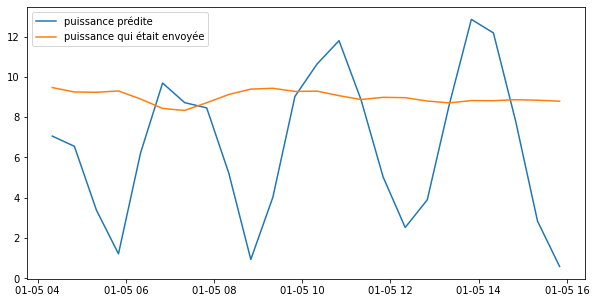

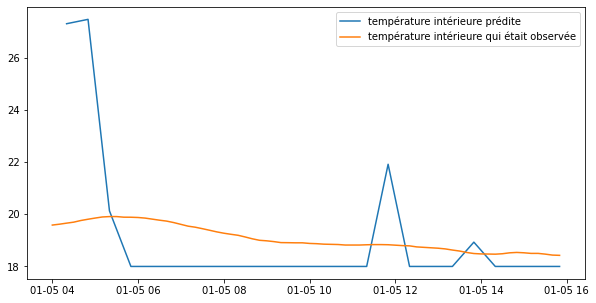

In [ ]:
i = 'SSH0000001'
print(i)
p_pred = []
p_real = []
T_pred = []
for t in Tps:
  p_pred.append(P[i][t].varValue)
  p_real.append(puissances_surf[i][t] * surface[i] * 10**(-6))
  T_pred.append(T[i][t].varValue)

plt.figure(figsize=(10,5))
dates = list(df_data.loc[indexs_skid]['DT'])
plt.plot(dates[12+2::3], p_pred, label='puissance prédite')            # [12+2::3] car on ne prédit pas sur les 12 premières valeurs, on commence au troisième éléments (indice n°2)
plt.plot(dates[12+2::3], p_real, label='puissance qui était envoyée')  #  et puis en va de 3 en 3 pour avoir une données toutes les 30 minutes
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.plot(dates[12+2::3], T_pred, label='température intérieure prédite')
plt.plot(dates[12:], list(temperatures_int[i].values())[12:], label='température intérieure qui était observée')
plt.legend()
plt.show()

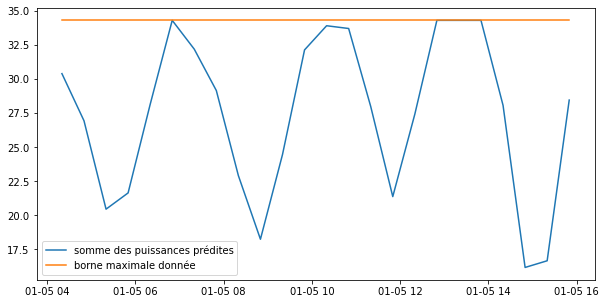

In [ ]:
SommePuissances = []
Borne = []
for t in Tps:
  SommePuissances.append(sum([P[i][t].varValue for i in skids]))
  Borne.append(Pmax)

#Affiche des sommes de puissances toutes les 30min :
plt.figure(figsize=(10,5))
dates = list(df_data.loc[indexs_skid]['DT'])
plt.plot(dates[12+2::3], SommePuissances, label='somme des puissances prédites')
plt.plot(dates[12+2::3], Borne, label='borne maximale donnée') 
plt.legend()
plt.show()

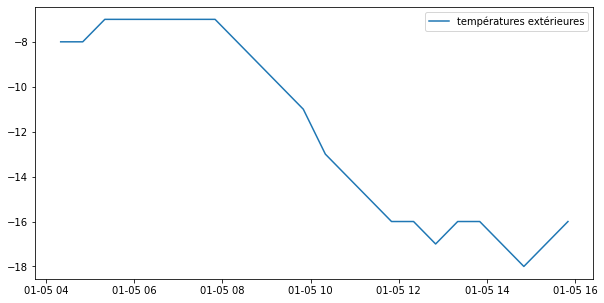

In [ ]:
T_ext = []
for t in Tps:
  T_ext.append(temperatures_ext[t])

plt.figure(figsize=(10,5))
dates = list(df_data.loc[indexs_skid]['DT'])
plt.plot(dates[12+2::3], T_ext, label='températures extérieures')
plt.legend()
plt.show()